In [ ]:
%matplotlib inline


Autograd: automatic differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Variable
--------

``autograd.Variable`` is the central class of the package. It wraps a
Tensor, and supports nearly all of operations defined on it. Once you
finish your computation you can call ``.backward()`` and have all the
gradients computed automatically.

You can access the raw tensor through the ``.data`` attribute, while the
gradient w.r.t. this variable is accumulated into ``.grad``.

.. figure:: /_static/img/Variable.png
   :alt: Variable

   Variable

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Variable`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each variable has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Variable`` (except for Variables created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Variable``. If ``Variable`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``grad_output``
argument that is a tensor of matching shape.



In [1]:
import torch
from torch.autograd import Variable

Create a variable:



In [2]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [8]:
x.requires_grad

True

Do an operation of variable:



In [3]:
y = x + 2
print(y)

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]



``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [9]:
print(y.grad_fn)

AttributeError: grad_fn

Do more operations on y



In [5]:
z = y * y * 3
out = z.mean()

print(z, out)

Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
 Variable containing:
 27
[torch.FloatTensor of size 1]



Gradients
---------
let's backprop now
``out.backward()`` is equivalent to doing ``out.backward(torch.Tensor([1.0]))``



In [10]:
out.backward()

print gradients d(out)/dx




In [11]:
print(x.grad)

Variable containing:
 4.5000  4.5000
 4.5000  4.5000
[torch.FloatTensor of size 2x2]



You should have got a matrix of ``4.5``. Let’s call the ``out``
*Variable* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



You can do many crazy things with autograd!



In [12]:
x = torch.randn(3)
x = Variable(x, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

Variable containing:
 1208.4890
 -425.8905
  110.1804
[torch.FloatTensor of size 3]



In [13]:
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

print(x.grad)

Variable containing:
  51.2000
 512.0000
   0.0512
[torch.FloatTensor of size 3]



**Read Later:**

Documentation of ``Variable`` and ``Function`` is at
http://pytorch.org/docs/autograd



Demo: Linear Regression
-----------------------


In [80]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Hyper Parameters
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

In [82]:
# Toy Dataset 
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

In [83]:
# Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        nn.Module.__init__(self)
        #super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [84]:
model = LinearRegression(input_size, output_size)

In [85]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent

In [86]:
# Train the Model 
for epoch in range(num_epochs):
    # Convert numpy array to torch Variable
    inputs = Variable(torch.from_numpy(x_train))
    targets = Variable(torch.from_numpy(y_train))

    # Forward + Backward + Optimize
    optimizer.zero_grad()  # zero gradients
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()  # compute new gradients
    optimizer.step()  # SGD step
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [%d/%d], Loss: %.4f' 
               %(epoch+1, num_epochs, loss.data[0]))

Epoch [5/60], Loss: 9.9577
Epoch [10/60], Loss: 4.1744
Epoch [15/60], Loss: 1.8314
Epoch [20/60], Loss: 0.8821
Epoch [25/60], Loss: 0.4975
Epoch [30/60], Loss: 0.3415
Epoch [35/60], Loss: 0.2782
Epoch [40/60], Loss: 0.2525
Epoch [45/60], Loss: 0.2420
Epoch [50/60], Loss: 0.2376
Epoch [55/60], Loss: 0.2357
Epoch [60/60], Loss: 0.2349


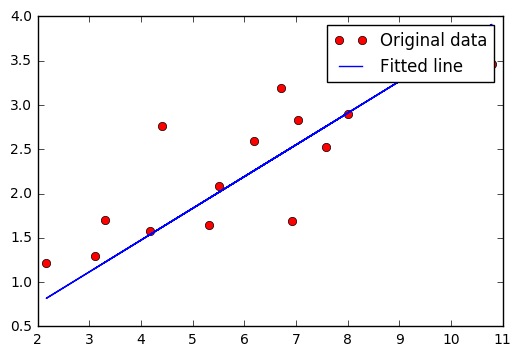

In [87]:
# Plot the graph
predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

In [88]:
# Save the Model (binary)
torch.save(model.state_dict(), 'model.pkl')

Demo: Logistic Regression for Image Classification for MNIST
----------------------------------------------------------

In [89]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [90]:
# Hyper Parameters 
input_size = 784 # 28 x 28
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [91]:
# MNIST Dataset (Images and Labels)
# This will take a bit of time to download...
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Files already downloaded


In [92]:
# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [93]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [94]:
# Examine your dataset!
for images, labels in test_loader:
    break
imshow(vutils.make_grid(images, nrow=10))

In [95]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [96]:
model = LogisticRegression(input_size, num_classes)

Create your own Optimizer:

In [100]:
# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
# TODO: create a SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent

Define the training procedure:

In [102]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        # TODO: Fill in this section!
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch: [1/5], Step: [100/600], Loss: 2.2738
Epoch: [1/5], Step: [200/600], Loss: 2.1211
Epoch: [1/5], Step: [300/600], Loss: 2.0231
Epoch: [1/5], Step: [400/600], Loss: 1.9717
Epoch: [1/5], Step: [500/600], Loss: 1.8848
Epoch: [1/5], Step: [600/600], Loss: 1.7751
Epoch: [2/5], Step: [100/600], Loss: 1.7272
Epoch: [2/5], Step: [200/600], Loss: 1.6720
Epoch: [2/5], Step: [300/600], Loss: 1.6235
Epoch: [2/5], Step: [400/600], Loss: 1.5236
Epoch: [2/5], Step: [500/600], Loss: 1.5421
Epoch: [2/5], Step: [600/600], Loss: 1.4891
Epoch: [3/5], Step: [100/600], Loss: 1.4601
Epoch: [3/5], Step: [200/600], Loss: 1.4084
Epoch: [3/5], Step: [300/600], Loss: 1.4101
Epoch: [3/5], Step: [400/600], Loss: 1.2909
Epoch: [3/5], Step: [500/600], Loss: 1.2714
Epoch: [3/5], Step: [600/600], Loss: 1.3330
Epoch: [4/5], Step: [100/600], Loss: 1.2651
Epoch: [4/5], Step: [200/600], Loss: 1.1251
Epoch: [4/5], Step: [300/600], Loss: 1.2280
Epoch: [4/5], Step: [400/600], Loss: 1.2254
Epoch: [4/5], Step: [500/600], L

In [103]:
# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images: 82 %


In [104]:
# Save the Model
torch.save(model.state_dict(), 'mnist_model.pkl')